In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Carregar a base enviada pelo usuário
df_suja = pd.read_csv("base_fermentacao_suja_5000.csv")

# Verificar primeiras linhas e tipos de dados
df_suja.info(), df_suja.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperatura (°C)       4700 non-null   float64
 1   pH                     5000 non-null   float64
 2   Tempo (h)              4800 non-null   float64
 3   Glicose (g/L)          5000 non-null   float64
 4   Agitação (rpm)         4850 non-null   float64
 5   Tipo de Fermentador    4402 non-null   object 
 6   Operador Responsável   4256 non-null   object 
 7   Rendimento Etanol (%)  5000 non-null   float64
dtypes: float64(6), object(2)
memory usage: 312.6+ KB


(None,
    Temperatura (°C)    pH  Tempo (h)  Glicose (g/L)  Agitação (rpm)  \
 0             30.62  4.79       25.5          150.0           246.0   
 1             39.26  4.95       24.0          174.7           136.9   
 2             35.98  5.71       18.3          156.3           169.3   
 3             33.98  4.68       33.9          108.3           232.7   
 4             27.34  5.74       29.2          118.6           196.4   
 
   Tipo de Fermentador Operador Responsável  Rendimento Etanol (%)  
 0              Tipo B         Desconhecido                  42.08  
 1              Tipo B               Carlos                  45.71  
 2                 NaN                Bruno                  41.68  
 3              Tipo A                  NaN                  45.01  
 4        Desconhecido                  NaN                  25.93  )

In [ ]:
# Verificando estatísticas e valores ausentes da base original suja
missing = df_suja.isnull().sum()
desc = df_suja.describe(include='all')

# Exibir resumo para tomada de decisão de limpeza
missing, desc.T[['count', 'mean', 'std', 'min', 'max']]


(Temperatura (°C)         300
 pH                         0
 Tempo (h)                200
 Glicose (g/L)              0
 Agitação (rpm)           150
 Tipo de Fermentador      598
 Operador Responsável     744
 Rendimento Etanol (%)      0
 dtype: int64,
                         count        mean          std    min     max
 Temperatura (°C)       4700.0   32.435966      4.35314   25.0    40.0
 pH                     5000.0    4.685004     1.418029   -1.0     6.0
 Tempo (h)              4800.0   30.012771    10.456259   12.0    48.0
 Glicose (g/L)          5000.0    741.7513  2339.202916  100.0  9999.0
 Agitação (rpm)         4850.0  201.710804    57.841008  100.0   300.0
 Tipo de Fermentador      4402         NaN          NaN    NaN     NaN
 Operador Responsável     4256         NaN          NaN    NaN     NaN
 Rendimento Etanol (%)  5000.0   41.241004     9.440112   9.45   69.62)

In [ ]:
# Cópia da base para tratamento
df_limpa = df_suja.copy()

# Remover valores ausentes nas variáveis usadas
df_limpa = df_limpa.dropna(subset=["Tempo (h)", "Rendimento Etanol (%)", "pH", "Temperatura (°C)", "Glicose (g/L)"])

# Filtrar valores plausíveis
df_limpa = df_limpa[
    (df_limpa["pH"].between(3.5, 6.0)) &
    (df_limpa["Glicose (g/L)"] <= 300) &
    (df_limpa["Tempo (h)"].between(12, 48))
]

# Verificar tamanho final da base limpa
df_limpa.shape

(4043, 8)

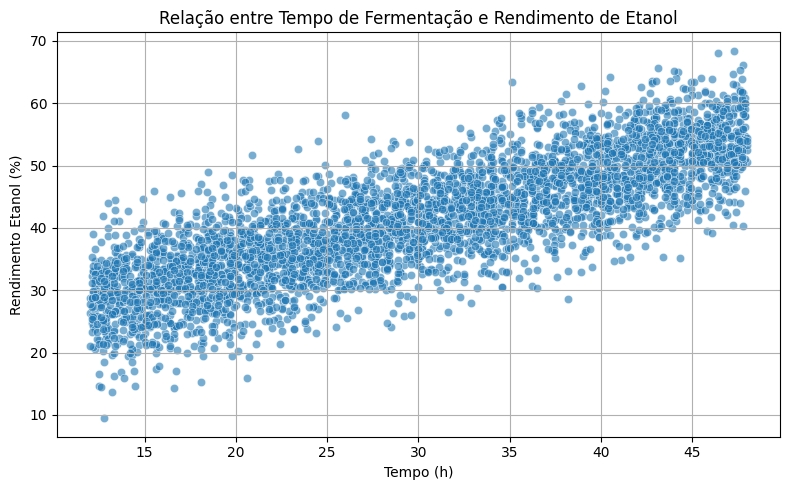

In [ ]:
# Visualização inicial
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Tempo (h)', y='Rendimento Etanol (%)', data=df_limpa, alpha=0.6)
plt.title('Relação entre Tempo de Fermentação e Rendimento de Etanol')
plt.xlabel('Tempo (h)')
plt.ylabel('Rendimento Etanol (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Ajuste do modelo
X = sm.add_constant(df_limpa["Tempo (h)"])
y = df_limpa["Rendimento Etanol (%)"]
modelo = sm.OLS(y, X).fit()

In [ ]:
# Previsão para 30 horas de fermentação
entrada_30h = pd.DataFrame({"const": [1], "Tempo (h)": [30]})
pred_30h = modelo.predict(entrada_30h).iloc[0]

In [ ]:
# Cálculo do erro médio (RMSE)
y_pred = modelo.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
# Intervalo de confiança para o coeficiente (95%)
conf_int = modelo.conf_int(alpha=0.05)
conf_int.columns = ["IC 2.5%", "IC 97.5%"]

In [ ]:
# Tabela final de resultados
resultados_finais = {
    "Equação estimada": f"Y = {modelo.params[0]:.2f} + {modelo.params[1]:.2f} * Tempo",
    "Coeficiente angular (Tempo)": f"{modelo.params[1]:.4f}",
    "Valor-p do Tempo": f"{modelo.pvalues[1]:.4f}",
    "R²": f"{modelo.rsquared:.4f}",
    "Rendimento previsto para 30h": f"{pred_30h:.2f}%",
    "RMSE (erro médio)": f"{rmse:.2f}",
    "IC 95% Tempo (coef.)": f"[{conf_int.loc['Tempo (h)', 'IC 2.5%']:.2f}, {conf_int.loc['Tempo (h)', 'IC 97.5%']:.2f}]"
}

/tmp/ipython-input-2358456100.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Equação estimada": f"Y = {modelo.params[0]:.2f} + {modelo.params[1]:.2f} * Tempo",
/tmp/ipython-input-2358456100.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Coeficiente angular (Tempo)": f"{modelo.params[1]:.4f}",
/tmp/ipython-input-2358456100.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Valor-p do Tempo": f"{modelo.pvalues[1]:.4f}",


In [ ]:
# Mostrar resultados em formato de tabela (Colab)
resultados_df = pd.DataFrame.from_dict(resultados_finais, orient='index', columns=["Resultado"])
display(resultados_df)

,Resultado
Equação estimada,Y = 19.15 + 0.73 * Tempo
Coeficiente angular (Tempo),0.7335
Valor-p do Tempo,0.0000
R²,0.6575
Rendimento previsto para 30h,41.16%
RMSE (erro médio),5.51
IC 95% Tempo (coef.),"[0.72, 0.75]"
